In [165]:
import torch
import torch.distributions as dist
import numpy as np
import matplotlib.pyplot as plt
import monai
from monai.transforms import LoadImage
import os
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans
from jqmcvi import base
from mpl_toolkits.mplot3d import Axes3D

In [20]:
# ASSUMING HD-BET IS DONE ON THE IMAGES : swi_bet.nii.gz
dat_dir = "/Workspace/Data/"
all_dir = os.listdir(dat_dir)
all_dir = [all_dir[i] if all_dir[i].isdigit() else all_dir.pop(i) for i in range(len(all_dir))]
all_dir = [os.path.join(dat_dir, patient) for patient in all_dir]

In [ ]:
for patient in all_dir:
    patient = os.path.join(patient, "swi.nii.gz")
    img = LoadImage(image_only=True, ensure_channel_first=True, simple_keys=True)(patient)
    for i in range(len(img[0][0, 0, :])):
        slice = img[0][:,:,i]
        # flatten
        slice = slice.flatten().astype(np.float32)
        # normalize
    

<hr style="color:red">
 Below are test cells
<hr style="color:red">

In [21]:
a = os.path.join(all_dir[0], "swi.nii.gz")
b = LoadImage(image_only=True, ensure_channel_first=True, simple_keys=True)(a)

In [82]:
slice = b[0][:,:,0]
slice.shape

torch.Size([320, 352])

In [153]:
b_reshape = b[0].flatten().reshape(-1, 1)
b_reshape.shape

torch.Size([9011200, 1])

In [154]:
# Dunn index calculation
k = KMeans(n_clusters=25, n_init='auto')
pred = k.fit_predict(b_reshape)
pred.shape

(9011200,)

In [155]:
concat = np.concatenate((b_reshape, pred.reshape(-1, 1)), axis=1)
concat.shape
# Of a row 'concat[n]', the 1st index is data, 2nd is the cluster label for it

(9011200, 2)

In [203]:
# a slice
# rng: list of number of clusters to try. ex> np.arange(3, 50)
def best_n(img, rng):
    flat = img.flatten().reshape(-1, 1)
    dunns = []
    for n in rng:
        k = KMeans(n_clusters=n, n_init='auto')
        pred = k.fit_predict(flat)
        concat = np.concatenate((flat, pred.reshape(-1, 1)), axis=1)
        clusters = []
        for i in range(n):
            clusters.append(concat[:, 0][concat[:, 1]==i])
        dunns.append((n, base.dunn(clusters)))
    return max(dunns)

In [ ]:
# calculate dunn indices of each slice
dunz = []
rng = np.arange(3, 50)
for i in range(b[0].shape[2]):
    dunz.append((i, best_n(b[0][:, :, i], rng)))

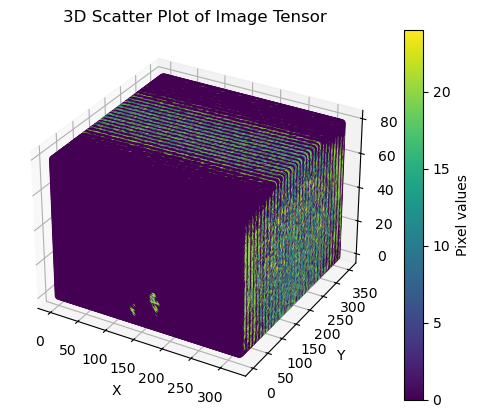

In [167]:
width, height, depth = pred.reshape(b[0].shape).shape
x, y, z = np.meshgrid(np.arange(width), np.arange(height), np.arange(depth))

x_flat = x.flatten()
y_flat = y.flatten()
z_flat = z.flatten()
values_flat = pred.reshape(b[0].shape).flatten()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x_flat, y_flat, z_flat, c=values_flat, cmap='viridis')
fig.colorbar(scatter, label='Pixel values')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Scatter Plot of Image Tensor')
plt.show()


In [ ]:
# Empirical observation
plt.hist(orig_slice, bins=100, color='blue', alpha=0.7)
plt.title('histo of swi pix intensities')
plt.xlabel('Pix intens')
plt.ylabel('Freq')
plt.grid(True)
plt.xlim((1, 150))
plt.show()